1. What's the size of the histogram-based method and the KDE-based method? How about the size of the sampling-based one?

2. Accuracy

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from distutils.version import LooseVersion
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from collections import Counter
from sklearn.model_selection import GridSearchCV
import scipy
from scipy import integrate
import timeit
import pickle
import sys
# import scipy.integrate

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

## Read in Data

In [257]:
import pyspark
import pyspark.sql
from pyspark.sql import *
import pyspark.sql.functions as f
from pyspark.sql.functions import col
import numpy as np 
import pandas as pd

from pyspark import broadcast

def broadcast_dump(self, value, f):
    pickle.dump(value, f, 4)  # was 2, 4 is first protocol supporting >4GB
    f.close()
    return f.name
broadcast.Broadcast.dump = broadcast_dump

conf = pyspark.SparkConf().setMaster("local[*]").setAll([
                                   ('spark.executor.memory', '5g'),  # find
                                   ('spark.driver.memory','15g'), # your
                                   ('spark.driver.maxResultSize', '8G') # setup
                                  ])
# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# create the context
sc = spark.sparkContext

# FIX for Spark 2.x
locale = sc._jvm.java.util.Locale
locale.setDefault(locale.forLanguageTag("en-US"))

In [293]:
lineitem = spark.read.parquet("/Users/futongliu/Downloads/SemesterProject/tpch_parquet_sf1/lineitem.parquet")
order = spark.read.parquet("/Users/futongliu/Downloads/SemesterProject/tpch_parquet_sf1/order.parquet")
supplier = spark.read.parquet("/Users/futongliu/Downloads/SemesterProject/tpch_parquet_sf1/supplier.parquet")
partsupp = spark.read.parquet("/Users/futongliu/Downloads/SemesterProject/tpch_parquet_sf1/partsupp.parquet")
part = spark.read.parquet("/Users/futongliu/Downloads/SemesterProject/tpch_parquet_sf1/part.parquet")
customer = spark.read.parquet("/Users/futongliu/Downloads/SemesterProject/tpch_parquet_sf1/customer.parquet")

In [40]:
lineitem.printSchema()

root
 |-- l_orderkey: long (nullable = true)
 |-- l_partkey: long (nullable = true)
 |-- l_suppkey: long (nullable = true)
 |-- l_linenumber: integer (nullable = true)
 |-- l_quantity: decimal(12,2) (nullable = true)
 |-- l_extendedprice: decimal(12,2) (nullable = true)
 |-- l_discount: decimal(12,2) (nullable = true)
 |-- l_tax: decimal(12,2) (nullable = true)
 |-- l_returnflag: string (nullable = true)
 |-- l_linestatus: string (nullable = true)
 |-- l_shipdate: date (nullable = true)
 |-- l_commitdate: date (nullable = true)
 |-- l_receiptdate: date (nullable = true)
 |-- l_shipinstruct: string (nullable = true)
 |-- l_shipmode: string (nullable = true)
 |-- l_comment: string (nullable = true)



In [7]:
# partsupp.printSchema()

# Sampling-based QCSs

In [53]:
# Q1 Good
lineitem.groupBy("l_returnflag", "l_linestatus", "l_shipdate").count().count() / lineitem.count() 

0.0006360378689981946

In [298]:
# Q3 No join in the query but still can't work
large = order.join(lineitem, order.o_orderkey == lineitem.l_orderkey)#.join(customer, customer.c_custkey == order.o_custkey)
large.groupBy('o_custkey', 'o_orderdate', 'l_shipdate', 'l_orderkey', 'o_shippriority').count().count() * 100 / large.count() 

98.3639146406186

In [591]:
# Q5 
# l_orderkey = o_orderkey
# l_suppkey = s_suppkey

# large = order.join(lineitem, order.o_orderkey == lineitem.l_orderkey)
# large.groupBy("l_orderkey", "l_suppkey").count().count() * 100 / large.count()

large = supplier.join(lineitem, supplier.s_suppkey == lineitem.l_suppkey).join(order, order.o_orderkey == lineitem.l_orderkey)
large.groupBy('s_nationkey').count().count() * 100 / large.count()

0.25

In [38]:
# Q6 Good
lineitem.groupBy("l_quantity", "l_discount", "l_shipdate").count().count() * 100 / lineitem.count() 

22.449520638737322

In [302]:
# Q7 

# large = order.join(lineitem, order.o_orderkey == lineitem.l_orderkey)  
# large.groupBy("l_shipdate", "l_orderkey", "l_suppkey").count().count() * 100 / large.count()

large = supplier.join(lineitem, supplier.s_suppkey == lineitem.l_suppkey).join(order, order.o_orderkey == lineitem.l_orderkey)
large.groupBy("l_shipdate", 's_nationkey').count().count() * 100 / large.count()

# lineitem.groupBy("l_shipdate", "l_orderkey", "l_suppkey").count().count() * 100 / lineitem.count() 

1.0514537472828418

In [310]:
# Q9 Good if to join "lineitem" with "partsupp"

large = lineitem.join(order, order.o_orderkey == lineitem.l_orderkey).join(partsupp, (partsupp.ps_suppkey == lineitem.l_suppkey) & (partsupp.ps_partkey == lineitem.l_partkey))
large.groupBy("l_partkey", "l_suppkey").count().count() * 100 / large.count()

13.322985428784005

In [312]:
# Q10 Originally 34.505%

large = order.join(lineitem, order.o_orderkey == lineitem.l_orderkey)
large.groupBy("o_custkey", 'o_orderdate', "l_returnflag").count().count() * 100 / large.count()

# lineitem.groupBy("l_returnflag", "l_orderkey").count().count() * 100 / lineitem.count() 

34.405666185930684

In [44]:
# Q11 (?) There is no table lineitem in the query 
lineitem.groupBy("l_orderkey", "l_shipdate", "l_commitdate", "l_receiptdate", "l_shipmode").count().count() * 100 / lineitem.count() 

99.99988335695355

In [40]:
# Q12 modified, without join keys but still can't work 

large = order.join(lineitem, order.o_orderkey == lineitem.l_orderkey)
large.groupBy("l_shipmode", "l_commitdate", "l_receiptdate", "l_shipdate").count().count() * 100 / large.count()

# lineitem.groupBy("l_shipmode", "l_commitdate", "l_receiptdate", "l_shipdate").count().count() * 100 / lineitem.count() 

96.06101431126864

In [47]:
# Q17 

large = part.join(lineitem, part.p_partkey == lineitem.l_partkey)
large.groupBy("l_partkey", "p_brand", "p_container", "l_quantity").count().count() * 100 / large.count() # 75.277%

# large.groupBy("l_partkey", "l_quantity").count().count() * 100 / large.count() # 75.277%

# lineitem.groupBy("l_quantity").count().count() * 100 / lineitem.count() 

75.27702306949509

In [49]:
# Q18 modified, without join keys but still can't work 
lineitem.groupBy("l_orderkey", "l_quantity").count().count() * 100 / lineitem.count() 

96.09893996465716

In [49]:
# Q19 removed join key, seems good
large = part.join(lineitem, part.p_partkey == lineitem.l_partkey)
large.groupBy("l_partkey", "p_brand", "p_container", "p_size", "l_quantity", "l_shipinstruct", "l_shipmode").count().count() * 100 / large.count()
large.groupBy("l_partkey", "l_quantity", "l_shipinstruct", "l_shipmode").count().count() * 100 / large.count()

# lineitem.groupBy("l_quantity", "l_shipinstruct", "l_shipmode").count().count() * 100 / lineitem.count()

98.11034932092917

In [54]:
# Q20 removed join keys, seems good
# large = partsupp.join(lineitem, partsupp.ps_partkey == lineitem.l_partkey)
# large.groupBy("l_shipdate", "l_partkey", "l_suppkey", "ps_availqty").count().count() * 100 / large.count()

large = partsupp.join(lineitem, partsupp.ps_suppkey == lineitem.l_suppkey)
large.groupBy("l_shipdate", "l_partkey", "l_partkey", "ps_suppkey", "l_suppkey", "ps_availqty").count().count() * 100 / large.count()

# lineitem.groupBy("l_shipdate").count().count() * 100 / lineitem.count() 

99.44460996648179

In [ ]:
List(List("l_returnflag", "l_linestatus", "l_shipdate"), List("Q1")), //List(8, 9, 10) Q1
      List(List("l_orderkey", "l_shipdate"), List("Q3")), //List(0, 10) Q3
      List(List("l_orderkey", "l_suppkey"), List("Q5")), //List(0, 2) Q5
      List(List("l_quantity", "l_discount", "l_shipdate"), List("Q6")), //List(4, 6, 10) Q6
      List(List("l_shipdate"), List("Q7")), //Q7
      List(List("l_orderkey", "l_partkey", "l_suppkey"), List("Q9")), //List(0, 1, 2) Q9
      List(List("l_returnflag"), List("Q10")), //Q10
      List(List("l_orderkey", "l_shipdate", "l_commitdate", "l_receiptdate", "l_shipmode"), List("Q11")), //List(0, 10, 11, 12, 14) Q11
      List(List("l_partkey", "l_quantity"), List("Q12")), //List(1, 4) Q12
      List(List("l_quantity"), List("Q17")), //Q17
      List(List("l_orderkey", "l_quantity"), List("Q18")), //Q18
      List(List("l_quantity", "l_shipinstruct", "l_shipmode"), List("Q19")), //Q19
      List(List("l_shipdate"), List("Q20")) //Q20

# 1. KDE-Based Method

## 1. 1. Data Cleaning

In [262]:
lineitem_clean = lineitem.withColumn('l_shipdate', f.to_date('l_shipdate', 'yyyy-MM-dd'))
lineitem_schema = dict(zip(lineitem_clean.schema.names, range(len(lineitem_clean.schema.names)) ))

for col_name in lineitem.schema.names[:8]:
    lineitem_clean = lineitem_clean.withColumn(col_name, col(col_name).cast('float'))

In [263]:
lineitem_clean.show(2)

+----------+---------+---------+------------+----------+---------------+----------+-----+------------+------------+----------+------------+-------------+-----------------+----------+--------------------+
|l_orderkey|l_partkey|l_suppkey|l_linenumber|l_quantity|l_extendedprice|l_discount|l_tax|l_returnflag|l_linestatus|l_shipdate|l_commitdate|l_receiptdate|   l_shipinstruct|l_shipmode|           l_comment|
+----------+---------+---------+------------+----------+---------------+----------+-----+------------+------------+----------+------------+-------------+-----------------+----------+--------------------+
|       1.0| 155190.0|   7706.0|         1.0|      17.0|       21168.23|      0.04| 0.02|           N|           O|1996-03-13|  1996-02-12|   1996-03-22|DELIVER IN PERSON|     TRUCK|egular courts abo...|
|       1.0|  67310.0|   7311.0|         2.0|      36.0|       45983.16|      0.09| 0.06|           N|           O|1996-04-12|  1996-02-28|   1996-04-20| TAKE BACK RETURN|      MAIL|ly

## 1.2. Stratum -> KDE for Query 1: Construct the stratifed KDEs, store them in a hashMap

In [10]:
def compute_kdes(s_values, kernel='gaussian', bw=.01):
    '''
    Compute the KDE given the block that is already grouped by key 
    s_values[0]: stratum_str
    s_values[1]: iterable block of rows that is identified by this stratum_str
    '''
    stratum_str, iterable_rows = s_values[0], s_values[1]
    
    kdes_bank = dict()
    
    # Training Data
    X_l_quantity = np.array([])
    X_l_extendedprice = np.array([])
    X_l_discount = np.array([])
    X_l_extendedprice_discount = np.array([])
    X_l_extendedprice_discount_tax = np.array([])
    
    # Fill in the training data
    for row in iterable_rows:
        X_l_quantity = np.append(X_l_quantity, row['l_quantity'])
        X_l_extendedprice = np.append(X_l_extendedprice, row['l_extendedprice'])
        X_l_discount = np.append(X_l_discount, row['l_discount'])
        X_l_extendedprice_discount = np.append(X_l_extendedprice_discount, row['l_extendedprice'] * (1 - row['l_discount']))
        X_l_extendedprice_discount_tax = np.append(X_l_extendedprice_discount_tax, row['l_extendedprice'] * (1 - row['l_discount']) * (1 + row['l_tax']))
    
    # Store the trained model into the KDE bank
    kdes_bank['n'] = len(iterable_rows)
    kdes_bank['l_quantity'] = KernelDensity(kernel='gaussian', bandwidth= .1).fit(X_l_quantity.reshape(-1, 1))
    kdes_bank['l_extendedprice'] = KernelDensity(kernel='gaussian', bandwidth=bw).fit(transform(X_l_extendedprice).reshape(-1, 1))
    kdes_bank['l_discount'] = KernelDensity(kernel='gaussian', bandwidth=bw).fit(X_l_discount.reshape(-1, 1))
    kdes_bank['l_extendedprice_discount'] = KernelDensity(kernel='gaussian', bandwidth=bw).fit(transform(X_l_extendedprice_discount).reshape(-1, 1))
    kdes_bank['l_extendedprice_discount_tax'] = KernelDensity(kernel='gaussian', bandwidth=bw).fit(transform(X_l_extendedprice_discount_tax).reshape(-1, 1))
    
    stra_list = stratum_str.split("_")
    return stra_list + [stratum_str, kdes_bank]

In [72]:
def kde_based_method_construction(lineitem_clean):
    strat_kde = lineitem_clean.rdd\
        .map(lambda row: ("_".join([row['l_returnflag'], row['l_linestatus'], str(row['l_shipdate'])]), row )).groupByKey()\
        .map(lambda str_rows: compute_kdes(str_rows) )
    # (RDD) strat_kde: flag, status, date, stratum_str, kdes_bank
    
    hashMap_kde = {stratum_str: kde for stratum_str, kde in strat_kde.map(lambda row: (row[-2], row[-1])).collect()}
    # hashMap_kde: stratum_string -> Actual Kernel Density Estimation Models that corresponds to this stratum
    
    strata_catalogue = strat_kde.map(lambda row: row[:4]).toDF(["l_returnflag", "l_linestatus", "l_shipdate", "stratum_str"])
    # (DF) strata_catalogue: flag, status, date, stratum_str
    return strata_catalogue, hashMap_kde

## 1. 2. Testing - Q1

In [ ]:
select
	l_returnflag,
	l_linestatus,
	sum(l_quantity) as sum_qty,
	sum(l_extendedprice) as sum_base_price,
	sum(l_extendedprice * (1 - l_discount)) as sum_disc_price,
	sum(l_extendedprice * (1 - l_discount) * (1 + l_tax)) as sum_charge,
	avg(l_quantity) as avg_qty,
	avg(l_extendedprice) as avg_price,
	avg(l_discount) as avg_disc,
	count(*) as count_order
from
	lineitem
where
	l_shipdate <= date '1998-12-01' - interval ':1' day (3)
group by
	l_returnflag,
	l_linestatus
order by
	l_returnflag,
	l_linestatus

#### Helper Functions

In [12]:
def compute_error(Q1_approx, Q1_exact):
    df_2 = Q1_approx.toPandas().set_index(['l_returnflag', 'l_linestatus']).astype(float)
    df_1 = Q1_exact.toPandas().set_index(['l_returnflag', 'l_linestatus']).astype(float)
    return (df_2 - df_1) * 100 / df_1

In [13]:
def calculate_size_of(obj):
    p = pickle.dumps(obj)
    size = sys.getsizeof(p)
    print('The size of the object in MB: ', size / 2 ** 20)
    return size

### -> Exact

In [14]:
def compute_exact_result(lineitem, left_date, right_date):
    return lineitem.where((left_date<=f.col("l_shipdate")) & (f.col("l_shipdate")<=right_date))\
            .groupby("l_returnflag", "l_linestatus")\
            .agg(f.sum('l_quantity').alias('sum_qty'), f.sum('l_extendedprice').alias('sum_base_price'), \
                 f.sum(col('l_extendedprice') * (1 - col('l_discount'))).alias('sum_disc_price'),\
                 f.sum(col('l_extendedprice') * (1 - col('l_discount')) * (1 + col('l_tax'))).alias('sum_charge'),\
                 f.avg("l_quantity").alias('avg_qty'), f.avg('l_extendedprice').alias('avg_price'), \
                 f.avg('l_discount').alias('avg_disc'), f.count('*').alias('count_order') )\
            .sort("l_returnflag", "l_linestatus").cache()

In [316]:
from datetime import date, timedelta

left_date = date(1998, 12, 1) - timedelta(days = 10)
right_date= date(1998, 12, 1) + timedelta(days = 10)

mean = lineitem_clean.select(f.avg(f.col("l_extendedprice"))).first()['avg(l_extendedprice)']
std_dev = lineitem_clean.select(f.stddev(f.col("l_extendedprice"))).first()[0]
transform  =  lambda x: (x - mean) / std_dev
i_transform = lambda x: x * std_dev + mean

lower_bound = transform(lineitem_clean.select(f.min(col('l_extendedprice') * (1 - col('l_discount')) * (1 + col('l_tax')))).first()[0])
upper_bound = transform(lineitem_clean.select(f.max(col('l_extendedprice') * (1 - col('l_discount')) * (1 + col('l_tax')))).first()[0])

In [317]:
Q1_exact = compute_exact_result(lineitem, left_date, right_date)
Q1_exact.show()

+------------+------------+--------+--------------+--------------+---------------+---------+------------+--------+-----------+
|l_returnflag|l_linestatus| sum_qty|sum_base_price|sum_disc_price|     sum_charge|  avg_qty|   avg_price|avg_disc|count_order|
+------------+------------+--------+--------------+--------------+---------------+---------+------------+--------+-----------+
|           N|           O|34374.00|   52166985.30| 49487415.0516|51410150.791207|25.825695|39193.828174|0.051029|       1331|
+------------+------------+--------+--------------+--------------+---------------+---------+------------+--------+-----------+



### -> Approximated

### Implementation 

In [87]:
def kde_based_cal_result(row):
    '''
    Compute the result with the KDE models
    
    row: a row in RDD
    '''
    sum_qty, sum_base_price, sum_disc_price, sum_charge, avg_qty, avg_price, avg_disc, count_order = 0, 0, 0, 0, 0, 0, 0, 0
    sum_discount = 0
    for kde_key in row['collect_list(stratum_str)']:
        kdes_bank = broadcast_hashMap_kde.value[kde_key]
        n = kdes_bank['n']
        
        count_order += n
        sum_qty += n * integrate.quad(lambda x: x * np.exp(kdes_bank['l_quantity'].score_samples([[x]])), 0, 51)[0]
        sum_base_price += n * integrate.quad(lambda x: i_transform(x) * np.exp(kdes_bank['l_extendedprice'].score_samples([[x]])), lower_bound, upper_bound)[0]
        sum_discount += n * integrate.quad(lambda x: x * np.exp(kdes_bank['l_discount'].score_samples([[x]])), 0, 1)[0]
        sum_disc_price += n * integrate.quad(lambda x: i_transform(x) * np.exp(kdes_bank['l_extendedprice_discount'].score_samples([[x]])), lower_bound, upper_bound)[0]
        sum_charge += n * integrate.quad(lambda x: i_transform(x) * np.exp(kdes_bank['l_extendedprice_discount_tax'].score_samples([[x]])), lower_bound, upper_bound)[0]
        
    avg_qty = sum_qty / count_order
    avg_price = sum_base_price / count_order
    avg_disc = sum_discount / count_order
    return (row['l_returnflag'], row['l_linestatus'], sum_qty, sum_base_price, sum_disc_price, sum_charge, avg_qty, avg_price, avg_disc, count_order)


In [18]:
def kde_based_method_testing(strata_catalogue, hashMap_kde, left_date, right_date):
    '''
    
    strata_catalogue: pre-saved DF with schema: flag, status, date, stratum_str
    hashMap_kde: hashMap_kde: stratum_string -> Actual Kernel Density Estimation Models that corresponds to this stratum
    left_date, right_date: datetime objects
    
    '''
    qualified = strata_catalogue.where((left_date<=f.col("l_shipdate")) & (f.col("l_shipdate")<=right_date))\
                .groupby("l_returnflag", "l_linestatus").agg(f.collect_list("stratum_str"))
    # (DF) qualified: flag, status, collect_list('stratum_str')
    
    Q1_kde_approx = qualified.rdd.map(kde_based_cal_result)\
    .toDF(['l_returnflag','l_linestatus','sum_qty','sum_base_price', 'sum_disc_price', 'sum_charge', 'avg_qty', 'avg_price', 'avg_disc', 'count_order'])\
    .sort("l_returnflag", "l_linestatus")
    
    return Q1_kde_approx


In [318]:
# Driver Memory needs to be configured to store the result
start = timeit.default_timer()
strata_catelogue, hashMap_kde = kde_based_method_construction(lineitem_clean)
strata_catelogue = strata_catelogue.cache()
strata_catelogue.show()
stop = timeit.default_timer()
print('Construction time is ', stop - start)

+------------+------------+----------+--------------+
|l_returnflag|l_linestatus|l_shipdate|   stratum_str|
+------------+------------+----------+--------------+
|           N|           O|1996-03-13|N_O_1996-03-13|
|           N|           O|1996-04-12|N_O_1996-04-12|
|           N|           O|1996-01-29|N_O_1996-01-29|
|           N|           O|1996-04-21|N_O_1996-04-21|
|           N|           O|1996-03-30|N_O_1996-03-30|
|           N|           O|1996-01-30|N_O_1996-01-30|
|           N|           O|1997-01-28|N_O_1997-01-28|
|           R|           F|1994-02-02|R_F_1994-02-02|
|           R|           F|1993-11-09|R_F_1993-11-09|
|           A|           F|1994-01-16|A_F_1994-01-16|
|           A|           F|1993-12-04|A_F_1993-12-04|
|           R|           F|1993-12-14|R_F_1993-12-14|
|           A|           F|1993-10-29|A_F_1993-10-29|
|           N|           O|1996-01-10|N_O_1996-01-10|
|           R|           F|1994-10-31|R_F_1994-10-31|
|           R|           F|1

In [319]:
hashMap_kde

{'N_O_1996-03-13': {'n': 1,
  'l_quantity': KernelDensity(algorithm='auto', atol=0, bandwidth=0.1, breadth_first=True,
                kernel='gaussian', leaf_size=40, metric='euclidean',
                metric_params=None, rtol=0),
  'l_extendedprice': KernelDensity(algorithm='auto', atol=0, bandwidth=0.01, breadth_first=True,
                kernel='gaussian', leaf_size=40, metric='euclidean',
                metric_params=None, rtol=0),
  'l_discount': KernelDensity(algorithm='auto', atol=0, bandwidth=0.01, breadth_first=True,
                kernel='gaussian', leaf_size=40, metric='euclidean',
                metric_params=None, rtol=0),
  'l_extendedprice_discount': KernelDensity(algorithm='auto', atol=0, bandwidth=0.01, breadth_first=True,
                kernel='gaussian', leaf_size=40, metric='euclidean',
                metric_params=None, rtol=0),
  'l_extendedprice_discount_tax': KernelDensity(algorithm='auto', atol=0, bandwidth=0.01, breadth_first=True,
                kern

In [92]:
broadcast_hashMap_kde = sc.broadcast(hashMap_kde)
start = timeit.default_timer()
Q1_kde_approx = kde_based_method_testing(strata_catelogue, broadcast_hashMap_kde, left_date, right_date).cache()
Q1_kde_approx.show()
stop = timeit.default_timer()
print('Run time of KDE-based Method (second):', stop - start)

KeyboardInterrupt: 

In [585]:
compute_error(Q1_kde_approx, Q1_exact)

sum_qty  sum_base_price  sum_disc_price  \
l_returnflag l_linestatus                                                 
A            F            -2.008874e+01       -0.255221   -1.074108e+00   
N            F             9.558820e-11       -5.798489    2.498078e-07   
             O            -1.191187e+01       -4.015776   -2.207653e+00   
R            F            -1.428571e+01       -3.661590   -3.737818e+00   

                             sum_charge       avg_qty  avg_price  avg_disc  \
l_returnflag l_linestatus                                                    
A            F            -3.014713e+00 -2.008874e+01  -0.255221  0.870602   
N            F             1.951261e-07  9.559057e-11  -5.798489  2.405640   
             O            -1.813965e+00 -1.191187e+01  -4.015776  0.924532   
R            F            -3.939950e+00 -1.428571e+01  -3.661590  0.974401   

                           count_order  
l_returnflag l_linestatus               
A            F                     0.0  
N            F                     0.0  
             O                     0.0  
R            F                     0.0

In [588]:
compute_error(Q1_kde_approx, Q1_exact).mean()

sum_qty          -11.571581
sum_base_price    -3.432769
sum_disc_price    -1.754894
sum_charge        -2.192157
avg_qty          -11.571581
avg_price         -3.432769
avg_disc           1.293794
count_order        0.000000
dtype: float64

In [587]:
calculate_size_of(strata_catelogue.toPandas())
calculate_size_of(hashMap_kde)

The size of the object in MB:  0.038933753967285156
The size of the object in MB:  2.385425567626953


2501300

# Alternative to method 1: 
## Store the direct result (avg) of each stratum instead of the KDE

In [100]:
def compute_avgs(s_values):
    '''
    Compute the KDE given the block that is already grouped by key 
    s_values[0]: stratum_str
    s_values[1]: iterable block of rows that is identified by this stratum_str
    '''
    stratum_str, iterable_rows = s_values[0], s_values[1]
    
    avg_bank = dict()
    
    # Training Data
    X_l_quantity = np.array([])
    X_l_extendedprice = np.array([])
    X_l_discount = np.array([])
    X_l_extendedprice_discount = np.array([])
    X_l_extendedprice_discount_tax = np.array([])
    
    # Fill in the training data
    for row in iterable_rows:
        X_l_quantity = np.append(X_l_quantity, row['l_quantity'])
        X_l_extendedprice = np.append(X_l_extendedprice, row['l_extendedprice'])
        X_l_discount = np.append(X_l_discount, row['l_discount'])
        X_l_extendedprice_discount = np.append(X_l_extendedprice_discount, row['l_extendedprice'] * (1 - row['l_discount']))
        X_l_extendedprice_discount_tax = np.append(X_l_extendedprice_discount_tax, row['l_extendedprice'] * (1 - row['l_discount']) * (1 + row['l_tax']))
    
    # Store the trained model into the KDE bank
    avg_bank['n'] = len(iterable_rows)
    avg_bank['l_quantity'] = np.mean(X_l_quantity)
    avg_bank['l_extendedprice'] = np.mean(X_l_extendedprice)
    avg_bank['l_discount'] = np.mean(X_l_discount)
    avg_bank['l_extendedprice_discount'] = np.mean(X_l_extendedprice_discount)
    avg_bank['l_extendedprice_discount_tax'] = np.mean(X_l_extendedprice_discount_tax)
    
    stra_list = stratum_str.split("_")
    return stra_list + [stratum_str, avg_bank]

In [101]:
def avg_based_method_construction(lineitem_clean):
    strat_avg = lineitem_clean.rdd\
        .map(lambda row: ("_".join([row['l_returnflag'], row['l_linestatus'], str(row['l_shipdate'])]), row )).groupByKey()\
        .map(lambda str_rows: compute_avgs(str_rows))
    # (RDD) strat_avg: flag, status, date, stratum_str, avg_bank
    
    hashMap_avg = {stratum_str: avg for stratum_str, avg in strat_avg.map(lambda row: (row[-2], row[-1])).collect()}
    # hashMap_kde: stratum_string -> Actual Kernel Density Estimation Models that corresponds to this stratum
    
    strata_catalogue = strat_avg.map(lambda row: row[:4]).toDF(["l_returnflag", "l_linestatus", "l_shipdate", "stratum_str"])
    # (DF) strata_catalogue: flag, status, date, stratum_str
    return strata_catalogue, hashMap_avg

In [193]:
def avg_based_cal_result(row):
    '''
    Compute the result with the avgs of each stratum
    
    row: a row in RDD
    '''
    sum_qty, sum_base_price, sum_disc_price, sum_charge, avg_qty, avg_price, avg_disc, count_order = 0, 0, 0, 0, 0, 0, 0, 0
    sum_discount = 0
    for avg_key in row['collect_list(stratum_str)']:
        avg_bank = broadcast_hashMap_avg.value[avg_key]
        n = avg_bank['n']
        
        count_order += n
        sum_qty += n * avg_bank['l_quantity']
        sum_base_price += n * avg_bank['l_extendedprice']
        sum_discount += n * avg_bank['l_discount']
        sum_disc_price += n * avg_bank['l_extendedprice_discount']
        sum_charge += n * avg_bank['l_extendedprice_discount_tax']
        
    avg_qty = sum_qty / count_order
    avg_price = sum_base_price / count_order
    avg_disc = sum_discount / count_order
    return (row['l_returnflag'], row['l_linestatus'], float(sum_qty), float(sum_base_price), float(sum_disc_price), float(sum_charge), float(avg_qty), float(avg_price), float(avg_disc), float(count_order))


In [177]:
def avg_based_method_testing(strata_catelogue, left_date, right_date):
    '''
    
    strata_catalogue: pre-saved DF with schema: flag, status, date, stratum_str
    hashMap_kde: hashMap_kde: stratum_string -> Actual Kernel Density Estimation Models that corresponds to this stratum
    left_date, right_date: datetime objects
    
    '''
    qualified = strata_catelogue.where((left_date<=f.col("l_shipdate")) & (f.col("l_shipdate")<=right_date))\
                .groupby("l_returnflag", "l_linestatus").agg(f.collect_list("stratum_str"))
    # (DF) qualified: flag, status, collect_list('stratum_str')
    
    Q1_avg_approx = qualified.rdd.map(avg_based_cal_result)\
    .toDF(['l_returnflag','l_linestatus','sum_qty','sum_base_price', 'sum_disc_price', 'sum_charge', 'avg_qty', 'avg_price', 'avg_disc', 'count_order'])\
    .sort("l_returnflag", "l_linestatus")
    
    return Q1_avg_approx


In [104]:
# Driver Memory needs to be configured to store the result
start = timeit.default_timer()
strata_catelogue, hashMap_avg = avg_based_method_construction(lineitem_clean)
strata_catelogue = strata_catelogue.cache()
strata_catelogue.show()
stop = timeit.default_timer()
print('Construction time is ', stop - start)

+------------+------------+----------+--------------+
|l_returnflag|l_linestatus|l_shipdate|   stratum_str|
+------------+------------+----------+--------------+
|           R|           F|1993-10-20|R_F_1993-10-20|
|           A|           F|1992-12-11|A_F_1992-12-11|
|           A|           F|1993-09-21|A_F_1993-09-21|
|           N|           F|1995-06-09|N_F_1995-06-09|
|           N|           O|1995-08-16|N_O_1995-08-16|
|           N|           O|1995-11-13|N_O_1995-11-13|
|           R|           F|1992-02-01|R_F_1992-02-01|
|           R|           F|1992-05-18|R_F_1992-05-18|
|           R|           F|1992-12-01|R_F_1992-12-01|
|           R|           F|1993-08-04|R_F_1993-08-04|
|           R|           F|1994-08-25|R_F_1994-08-25|
|           R|           F|1995-03-04|R_F_1995-03-04|
|           A|           F|1992-01-18|A_F_1992-01-18|
|           A|           F|1993-03-09|A_F_1993-03-09|
|           A|           F|1993-04-22|A_F_1993-04-22|
|           A|           F|1

In [138]:
broadcast_hashMap_avg = sc.broadcast(hashMap_avg)
start = timeit.default_timer()
Q1_avg_approx = avg_based_method_testing(strata_catelogue, left_date, right_date).cache()
Q1_avg_approx.show()
stop = timeit.default_timer()
print('Run time of AVG-based Method (second):', stop - start)

+------------+------------+-----------+--------------------+--------------------+--------------------+------------------+-----------------+--------------------+-----------+
|l_returnflag|l_linestatus|    sum_qty|      sum_base_price|      sum_disc_price|          sum_charge|           avg_qty|        avg_price|            avg_disc|count_order|
+------------+------------+-----------+--------------------+--------------------+--------------------+------------------+-----------------+--------------------+-----------+
|           A|           F|   720113.0|1.0791321227373047E9|1.0252493425643251E9|1.0665408428546588E9|25.456483314479637|38148.05298138096|  0.0498448105855414|      28288|
|           N|           F|   991417.0|1.4875047106322021E9| 1.413082168178065E9|  1.46964922264194E9|25.516471920522985|38284.46776733932|0.050093426752791215|      38854|
|           N|           O|7.6633518E7|1.149352104169027...|1.091895918972208...|1.135610242102121...| 25.50201963528761|38248.01561162

In [139]:
compute_error(Q1_avg_approx, Q1_exact)

sum_qty  sum_base_price  sum_disc_price  \
l_returnflag l_linestatus                                            
A            F                 0.0   -1.322317e-08   -2.036333e-08   
N            F                 0.0    1.695470e-08    8.772669e-09   
             O                 0.0    6.710483e-09   -2.300216e-10   
R            F                 0.0    1.233504e-08    6.640202e-09   

                             sum_charge       avg_qty     avg_price  avg_disc  \
l_returnflag l_linestatus                                                       
A            F            -6.719998e-08  1.235362e-06 -1.210819e-08 -0.000380   
N            F            -3.758958e-08 -3.114734e-07  1.655847e-08  0.000852   
             O            -4.649624e-08 -1.430131e-06  6.863800e-09  0.000519   
R            F            -3.947230e-08  1.832546e-06  1.131974e-08  0.000759   

                           count_order  
l_returnflag l_linestatus               
A            F                     0.0  
N            F                     0.0  
             O                     0.0  
R            F                     0.0

In [140]:
compute_error(Q1_avg_approx, Q1_exact).mean()

sum_qty           0.000000e+00
sum_base_price    5.694267e-09
sum_disc_price   -1.295121e-09
sum_charge       -4.768952e-08
avg_qty           3.315757e-07
avg_price         5.658455e-09
avg_disc          4.375947e-04
count_order       0.000000e+00
dtype: float64

In [146]:
print('The total size in MB', (calculate_size_of(strata_catelogue.toPandas()) + calculate_size_of(hashMap_avg)) / (2 ** 20))

The size of the object in MB:  0.1750955581665039
The size of the object in MB:  0.7968120574951172
The total size in MB 0.9719076156616211


## Performance
#### Error vs Selectivity; Runtime vs Selectivity

In [222]:
log_grid = np.logspace(2, 3.7, 100)
time_consumption = []
error_bank = []

for delta in log_grid:
    left_date, right_date = date(1998, 12, 1) - timedelta(days = delta), date(1998, 12, 1) + timedelta(days = delta)
    exact_ans = compute_exact_result(lineitem_clean, left_date, right_date)
    
    start = timeit.default_timer()
    approximated_ans = avg_based_method_testing(strata_catelogue, left_date, right_date).cache()
    mean_std = compute_error(approximated_ans, exact_ans).mean().mean(), compute_error(approximated_ans, exact_ans).mean().std()
    stop = timeit.default_timer()
    
    time_consumption.append(stop - start)
    error_bank.append(mean_std)

Text(0.5, 1.0, 'error vs length of date predicate')

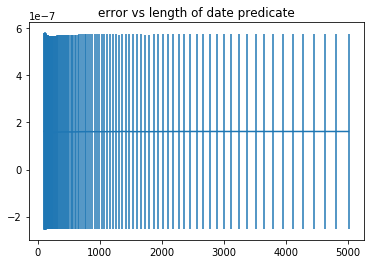

In [223]:
ax = plt.axes()
plt.errorbar(log_grid, [mean for mean, std in error_bank], yerr=[std for mean, std in error_bank])
ax.set_title("error vs length of date predicate")

Text(0.5, 1.0, 'Time vs length of date predicate')

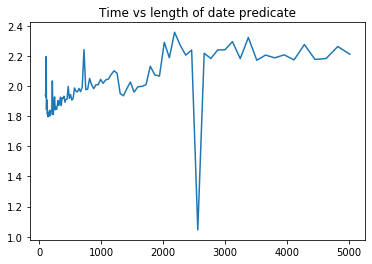

In [224]:
ax = plt.axes()
plt.plot(log_grid, time_consumption)
ax.set_title("Time vs length of date predicate")

In [315]:
np.mean(time_consumption)

1.9994624990698504

In [226]:
time_consumption.index(np.min(time_consumption))

82

In [227]:
# Weird point: when days delta is 2559
left_date, right_date = date(1998, 12, 1) - timedelta(days = 2559), date(1998, 12, 1) + timedelta(days = 2559)
exact_ans = compute_exact_result(lineitem_clean, left_date, right_date)

start = timeit.default_timer()
approximated_ans = avg_based_method_testing(strata_catelogue, left_date, right_date).cache()
mean_std = compute_error(approximated_ans, exact_ans).mean().mean(), compute_error(approximated_ans, exact_ans).mean().std()
stop = timeit.default_timer()

In [228]:
compute_error(approximated_ans, exact_ans)

sum_qty  sum_base_price  sum_disc_price  \
l_returnflag l_linestatus                                            
A            F                 0.0             0.0    1.089401e-07   
N            F                 0.0             0.0    1.169553e-07   
             O                 0.0             0.0    1.060542e-07   
R            F                 0.0             0.0    1.117027e-07   

                           sum_charge  avg_qty  avg_price  avg_disc  \
l_returnflag l_linestatus                                             
A            F               0.000001      0.0        0.0       0.0   
N            F               0.000001      0.0        0.0       0.0   
             O               0.000001      0.0        0.0       0.0   
R            F               0.000001      0.0        0.0       0.0   

                           count_order  
l_returnflag l_linestatus               
A            F                     0.0  
N            F                     0.0  
             O                     0.0  
R            F                     0.0

# 2. Histogram-Based Method
## 2.1. Compute Histograms

In [264]:
mean_disc = lineitem_clean.select(f.avg(f.col("l_discount"))).first()[0]
std_disc = lineitem_clean.select(f.stddev(f.col("l_discount"))).first()[0]

transform_disc = lambda x: (x - mean_disc) / std_disc
i_transform_disc = lambda x: x * std_disc + mean_disc

mean = lineitem_clean.select(f.avg(f.col("l_extendedprice"))).first()['avg(l_extendedprice)']
std_dev = lineitem_clean.select(f.stddev(f.col("l_extendedprice"))).first()[0]

transform  =  lambda x: (x - mean) / std_dev
i_transform = lambda x: x * std_dev + mean

In [234]:
def compute_hist(s_values):
    '''
    Compute the histogram bank given a already grouped dataframe
    '''
    stratum_str, iterable_rows = s_values[0], s_values[1]
    
    hist_bank = dict()
    
    # Training Data
    X_l_quantity = np.array([])
    X_l_extendedprice = np.array([])
    X_l_discount = np.array([])
    X_l_extendedprice_discount = np.array([])
    X_l_extendedprice_discount_tax = np.array([])
    
    # Fill in the training data
    for row in iterable_rows:
        X_l_quantity = np.append(X_l_quantity, row['l_quantity'])
        X_l_extendedprice = np.append(X_l_extendedprice, row['l_extendedprice'])
        X_l_discount = np.append(X_l_discount, row['l_discount'], 50)
        X_l_extendedprice_discount = np.append(X_l_extendedprice_discount, row['l_extendedprice'] * (1 - row['l_discount']))
        X_l_extendedprice_discount_tax = np.append(X_l_extendedprice_discount_tax, row['l_extendedprice'] * (1 - row['l_discount']) * (1 + row['l_tax']))
    
    # Store the histograms into the KDE bank
    hist_bank['l_quantity'] = np.histogram(X_l_quantity)
    hist_bank['l_extendedprice'] = np.histogram(transform(X_l_extendedprice))
    hist_bank['l_discount'] = np.histogram(transform_disc(X_l_discount))
    hist_bank['l_extendedprice_discount'] = np.histogram(transform(X_l_extendedprice_discount))
    hist_bank['l_extendedprice_discount_tax'] = np.histogram(transform(X_l_extendedprice_discount_tax))
    
    stra_list = stratum_str.split("_")
    return stra_list + [stratum_str, hist_bank]


def compute_result_by_hist(row):
    '''
    Compute the final result given a filtered strata dataFrame
    '''
    
    def cal_sum(histogram):
        count, edges = histogram
        midpoints = edges[:-1] + (edges[1] - edges[0]) / 2
        sum_ = np.sum(count * midpoints)
        return sum_

    sum_qty, sum_base_price, sum_disc_price, sum_charge, avg_qty, avg_price, avg_disc, count_order = 0, 0, 0, 0, 0, 0, 0, 0
    sum_discount = 0
    
    for hist_key in row['collect_list(stratum_str)']:
        hist_bank = hashMap_hist[hist_key]
        count_order += np.sum(hist_bank['l_quantity'][0])
        sum_qty += cal_sum(hist_bank['l_quantity'])
        sum_base_price += cal_sum((hist_bank['l_extendedprice'][0], i_transform(hist_bank['l_extendedprice'][1])) )
        sum_discount += cal_sum((hist_bank['l_discount'][0], i_transform_disc(hist_bank['l_discount'][1])))
        sum_disc_price += cal_sum((hist_bank['l_extendedprice_discount'][0], i_transform(hist_bank['l_extendedprice_discount'][1])) )
        sum_charge += cal_sum((hist_bank['l_extendedprice_discount_tax'][0], i_transform(hist_bank['l_extendedprice_discount_tax'][1])) )
        
    avg_qty = float(sum_qty / count_order)
    avg_price = float(sum_base_price / count_order)
    avg_disc = float(sum_discount / count_order)
    return (row['l_returnflag'], row['l_linestatus'], float(sum_qty), float(sum_base_price), float(sum_disc_price), float(sum_charge), avg_qty, avg_price, avg_disc, int(count_order))


In [235]:
def histogram_based_construction(lineitem_clean):
    strat_hist = lineitem_clean.rdd\
        .map(lambda row: ("_".join([row['l_returnflag'], row['l_linestatus'], str(row['l_shipdate'])]), row )).groupByKey()\
        .map(compute_hist)
    # (RDD) schema of strat_hist: returnflag, status, shipdate, stratum_str, hist_bank
    
    hashMap_hist = {stratum_str: hist for stratum_str, hist in strat_hist.map(lambda row: (row[-2], row[-1])).collect()}
    # (dict) hashMap_hist: stratum_str -> Histogram bank that corresponds to this stratum
    
    strata_catelogue = strat_hist.map(lambda row: row[:4]).toDF(["l_returnflag", "l_linestatus", "l_shipdate", "stratum_str"])
    # (DF) schema of strata_catelogue: flag, status, date, stratum_str
    return strata_catelogue, hashMap_hist
    
    
    
def histogram_based_testing(strata_catelogue, hashMap_hist, left_date, right_date):
    qualified = strata_catelogue.where((left_date<=f.col("l_shipdate")) & (f.col("l_shipdate")<=right_date))\
            .groupby("l_returnflag", "l_linestatus").agg(f.collect_list("stratum_str"))
    # (DF) schema of qualified: flag, status, collect_list("stratum_str")
    
    Q1_hist_approx = qualified.rdd.map(compute_result_by_hist)\
    .toDF(['l_returnflag','l_linestatus','sum_qty','sum_base_price', 'sum_disc_price', 'sum_charge', 'avg_qty', 'avg_price', 'avg_disc', 'count_order'])\
    .sort("l_returnflag", "l_linestatus").cache()
    
    return Q1_hist_approx

In [265]:
from datetime import date, timedelta

left_date = date(1998, 12, 1) - timedelta(days = 2000)
right_date= date(1998, 12, 1) + timedelta(days = 2000)

In [266]:
strata_catelogue, hashMap_hist = histogram_based_construction(lineitem_clean)

start = timeit.default_timer()
Q1_hist_approx = histogram_based_testing(strata_catelogue, hashMap_hist, left_date, right_date)
Q1_hist_approx.show()
stop = timeit.default_timer() 
print('Run time of Histogram-based Method (second):', stop - start)

+------------+------------+------------------+--------------------+-------------------+--------------------+------------------+------------------+--------------------+-----------+
|l_returnflag|l_linestatus|           sum_qty|      sum_base_price|     sum_disc_price|          sum_charge|           avg_qty|         avg_price|            avg_disc|count_order|
+------------+------------+------------------+--------------------+-------------------+--------------------+------------------+------------------+--------------------+-----------+
|           A|           F| 7333.600000000028|1.1103641767589228E7|1.053334571323911E7| 1.097209564730426E7|24.445333333333426|37012.139225297426|0.050342343418588925|        300|
|           N|           F|398.30000000000007|   598996.5703981866|  582435.7677822593|   599836.1863630221|28.450000000000006| 42785.46931415618|0.042816980538686836|         14|
|           N|           O| 25938.24999999974| 3.931047323399387E7|3.734896198240523E7| 3.8849815447

In [267]:
Q1_exact = compute_exact_result(lineitem_clean, left_date, right_date)
compute_error(Q1_hist_approx, Q1_exact)

sum_qty  sum_base_price  sum_disc_price  \
l_returnflag l_linestatus                                             
A            F             0.185792        1.530743        1.591609   
N            F             0.075377        0.389601        1.211880   
             O             0.070409        1.034504        1.003641   
R            F             0.133261        1.174442        1.440732   

                           sum_charge   avg_qty  avg_price  avg_disc  \
l_returnflag l_linestatus                                              
A            F               1.678289  0.185792   1.530743  1.428496   
N            F               0.781145  0.075377   0.389601  1.599616   
             O               1.035394  0.070409   1.034504  0.939076   
R            F               1.288691  0.133261   1.174442  1.474009   

                           count_order  
l_returnflag l_linestatus               
A            F                     0.0  
N            F                     0.0  
             O                     0.0  
R            F                     0.0

In [268]:
compute_error(Q1_hist_approx, Q1_exact).mean()

sum_qty           0.116210
sum_base_price    1.032322
sum_disc_price    1.311965
sum_charge        1.195880
avg_qty           0.116210
avg_price         1.032322
avg_disc          1.360299
count_order       0.000000
dtype: float64

In [269]:
compute_error(Q1_hist_approx, Q1_exact).mean().mean()

0.7706511039187594

In [270]:
(calculate_size_of(strata_catelogue.toPandas()) + calculate_size_of(hashMap_hist)) / (2 ** 20)

The size of the object in MB:  0.06882953643798828
The size of the object in MB:  2.140928268432617


2.2097578048706055

### Question: How does the error vary w.r.t. selectivity?

In [272]:
log_grid = np.logspace(2, 3.7, 10)
time_consumption_hist = []
error_bank_hist = []

for delta in log_grid:
    left_date, right_date = date(1998, 12, 1) - timedelta(days = delta), date(1998, 12, 1) + timedelta(days = delta)
    exact_ans = compute_exact_result(lineitem_clean, left_date, right_date)
    
    start = timeit.default_timer()
    approximated_ans = histogram_based_testing(strata_catelogue, hashMap_hist, left_date, right_date)
    temp = compute_error(approximated_ans, exact_ans).mean()
    mean_std = temp.mean(), temp.std()
    stop = timeit.default_timer()
    
    time_consumption_hist.append(stop - start)
    error_bank_hist.append(mean_std)

Text(0.5, 1.0, 'error vs length of date predicate')

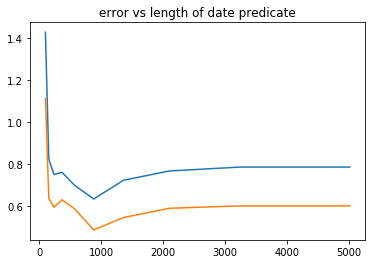

In [273]:
ax = plt.axes()
plt.plot(log_grid, error_bank_hist)
ax.set_title("error vs length of date predicate")

Text(0.5, 1.0, 'time vs length of date predicate')

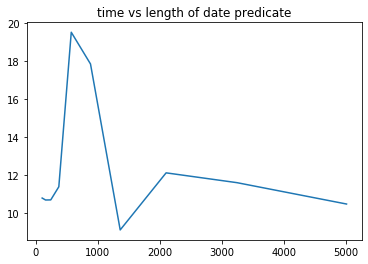

In [274]:
ax = plt.axes()
plt.plot(log_grid, time_consumption_hist)
ax.set_title("time vs length of date predicate")

In [281]:
np.mean(error_bank_hist)

0.726988546175048

## Space Complexity of naiive stratified sampling based method

In [279]:
SAMPLE_PATH = "/Users/futongliu/Downloads/SemesterProject/Sampling_based/Samples/"
calculate_size_of(spark.read.parquet(SAMPLE_PATH + 'Q1').toPandas())

The size of the object in MB:  2.2340173721313477


2342537

In [290]:
e = [-1.1253116458488908, -1.2596096595066817, -1.3661381981135043, -1.3800611354890828, -0.03075193208706, -0.16049826112595, 1.240776798266819,   -1.1086668531946895]
np.mean(e)

-0.64878261088738

In [ ]:
df_test = lineitem_clean.toPandas()

(45983.15999991032, 0.00015833799536157445)
(0.0, 0.0)


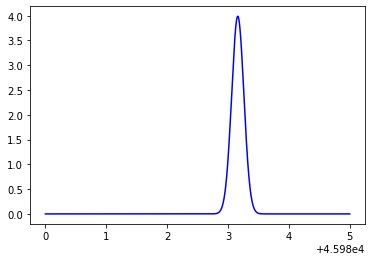

In [23]:
# kde = hashMap['N_O_1996-03-13']['l_extendedprice']

kde = KernelDensity(kernel='gaussian', bandwidth=.1).fit([[45983.16]])
X_plot = np.linspace(45980, 45985, 10000)
logdens = kde.score_samples(X_plot[:,None])
plt.plot(X_plot, np.exp(logdens), color='b')

print(integrate.quad(lambda x: x * np.exp(kde.score_samples([[x]])), 45980, 45985))
print(integrate.quad(lambda x: x * np.exp(kde.score_samples([[x]])), 0, 100000))

(0.9999999999998253, 8.073586947641615e-09)
(38365.76622035134, 0.00040594194508136727)
38365.766


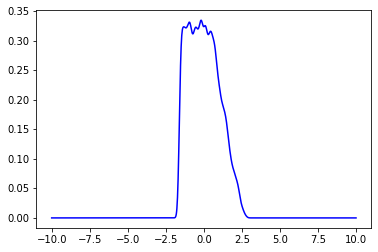

In [84]:
# transform = lambda x: (x - df_test.l_extendedprice.mean()) / df_test.l_extendedprice.std()
# inverse_t = lambda x: x * df_test.l_extendedprice.std() + df_test.l_extendedprice.mean()
test = df_test.l_extendedprice.values[:10000]
 
transform = lambda x: (x - np.mean(test)) / np.std(test)
inverse_t = lambda x: x * np.std(test) + np.mean(test)

kde = KernelDensity(kernel='gaussian', bandwidth=.1).fit(transform(test).reshape(-1, 1))
X_plot = np.linspace(-10, 10, 1000)
logdens = kde.score_samples(X_plot[:,None])
plt.plot(X_plot, np.exp(logdens), color='b')

print(integrate.quad(lambda x: np.exp(kde.score_samples([[x]])), -10, 10))
print(integrate.quad(lambda x: inverse_t(x) *  np.exp(kde.score_samples([[x]])), -10, 10))
print(np.mean(test))

In [241]:
kde1 = KernelDensity(kernel='gaussian', bandwidth=.1).fit([[1]])
kde2 = KernelDensity(kernel='gaussian', bandwidth=.1).fit([[2]])
kde1

KernelDensity(algorithm='auto', atol=0, bandwidth=0.1, breadth_first=True,
              kernel='gaussian', leaf_size=40, metric='euclidean',
              metric_params=None, rtol=0)

In [69]:
transform(test)

array([-1.1692787 ,  0.6952495 , -1.7597555 , -0.58415335, -1.0448325 ,
        0.96852404,  0.59842   ,  1.3019754 ,  0.75635934,  0.23749158],
      dtype=float32)

In [78]:
np.mean(test)

36730.113

# 3. KDE-Based Method constructed on the whole column

# COUNT

SELECT COUNT(l_quantity) \
FROM lineitem \
WHERE 10 <= l_quantity <= 20 

In [158]:
l_quantity = lineitem.select('l_quantity').toPandas().astype(int)

In [159]:
print(np.min(l_quantity.l_quantity.values), np.max(l_quantity.l_quantity.values))

1 50


### Exact

In [160]:
exact = lineitem.where((10 <= lineitem.l_quantity) &  (lineitem.l_quantity <= 20)).count()
exact

13

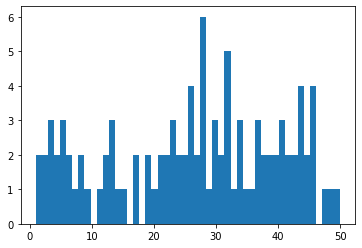

In [161]:
_ = plt.hist(l_quantity.values, bins=50)

## Get the Kernel Density Estimation

### Search for opt bandwidth

In [ ]:
from sklearn.model_selection import LeaveOneOut

X = l_quantity.values
params = {'bandwidth': np.linspace(.1, 10, 20)}
grid = GridSearchCV(KernelDensity(kernel='gaussian'), params, cv=5)
grid.fit(X)
print("bandwidth selcted : ", grid.best_estimator_.bandwidth)

The best possible bandwidth computed from grid search cross validation is largely different from the one computed from the actual error approximation function wrote below. 

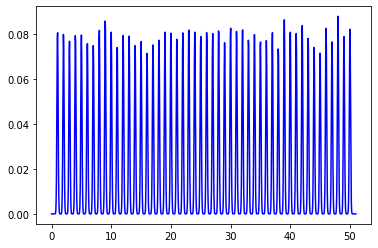

In [194]:
X = X.reshape(-1, 1)
X_plot = np.linspace(0, 51, 1000)
kde2 = KernelDensity(kernel='gaussian', bandwidth=.1).fit(X)
logdens = kde2.score_samples(X_plot[:,None])
plt.plot(X_plot, np.exp(logdens), color='b')

### Model with the opt bandwidth

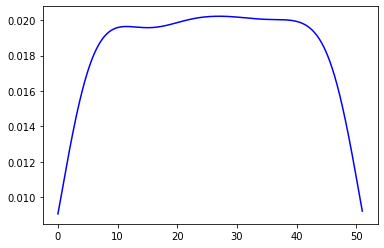

In [190]:
X = X.reshape(-1, 1)
X_plot = np.linspace(0, 51, 1000)
kde = KernelDensity(kernel='gaussian', bandwidth=4.2).fit(X)
logdens = kde.score_samples(X_plot[:,None])
plt.plot(X_plot, np.exp(logdens), color='b')

In [191]:
def aqp_count(kde, lower, upper, N):
    import scipy.integrate
    S = scipy.integrate.quad(lambda x: np.exp(kde.score_samples([[x]])), lower, upper)
    print("the estimated COUNT of rows", S[0] * N)
    return S[0] * N

In [193]:
approximated = aqp_count(kde, 10, 20, lineitem.count())
exact = lineitem.where((10 <= lineitem.l_quantity) & (lineitem.l_quantity <= 20)).count()
print("ERROR: ", np.abs((approximated-exact)/exact)*100 ,'%')

the estimated COUNT of rows 3930.056597411503
ERROR:  8.47562651580105 %


the estimated COUNT of rows 3888.9999999999886
the estimated COUNT of rows 3890.104368479405
the estimated COUNT of rows 3895.338101087064
the estimated COUNT of rows 3900.5860703059116
the estimated COUNT of rows 3905.5645309040606
the estimated COUNT of rows 3910.659410818016
the estimated COUNT of rows 3915.966651865316
the estimated COUNT of rows 3921.243362099518
the estimated COUNT of rows 3925.897086753841
the estimated COUNT of rows 3929.1024096377864
the estimated COUNT of rows 3930.0195972227534
the estimated COUNT of rows 3927.970139220217
the estimated COUNT of rows 3922.5133582187746
the estimated COUNT of rows 3913.4496994861843
the estimated COUNT of rows 3900.7882200743093
the estimated COUNT of rows 3884.7012615878516
the estimated COUNT of rows 3865.4771526137843
the estimated COUNT of rows 3843.476123838605
the estimated COUNT of rows 3819.092222449405
the estimated COUNT of rows 3792.7226439043325
4.257894736842105


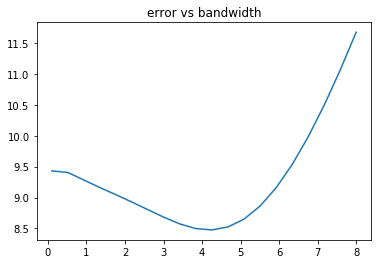

In [189]:
def errors_vs_bandwidth_skl(training_sample, bw_range):
    errors = []
    for bw in bw_range:
        kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(training_sample)
        approximated = aqp_count(kde, 10, 20, lineitem.count())
        exact = lineitem.where((10 <= lineitem.l_quantity) & (lineitem.l_quantity <= 20)).count()
        errors.append(np.abs((approximated-exact)/exact)*100)
    return errors
bw_range = np.linspace(0.1, 8, 20)
errors = errors_vs_bandwidth_skl(X, bw_range)
ax = plt.axes()
plt.plot(bw_range, errors)
ax.set_title("error vs bandwidth")
print( np.linspace(0.1, 8, 20)[errors.index(np.min(errors))] )

the estimated COUNT of rows 393.00001289931845
the estimated COUNT of rows 782.0000212121901
the estimated COUNT of rows 1181.500009459442
the estimated COUNT of rows 1952.0000117526406
the estimated COUNT of rows 3889.0000120391787
the estimated COUNT of rows 7934.500023218376
the estimated COUNT of rows 15974.499901677838


/Users/futongliu/opt/anaconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:3: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'error decreases when increasing the predicate window length')

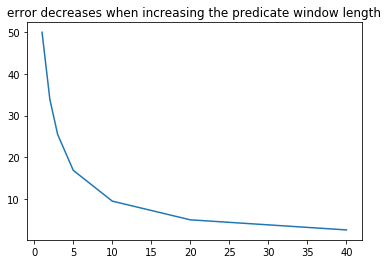

In [175]:
def error_vs_predicate_len(kde, len_range):
    errors = []
    for length in len_range:
        approximated = aqp_count(kde, 10, 10 +length, lineitem.count())
        exact = lineitem.where((10 <= lineitem.l_quantity) & (lineitem.l_quantity <= 10 +length)).count()
        errors.append(np.abs((approximated-exact)/exact)*100)
    return errors

len_range = [1, 2, 3, 5, 10, 20, 40]
errors = error_vs_predicate_len(kde, len_range)
ax = plt.axes()
plt.plot(len_range, errors)
ax.set_title("error decreases when increasing the predicate window length")

estimated count:  3888.999999999999
estimated count:  3898.7797117037317
estimated count:  3912.186717691456
estimated count:  3925.636268052375
estimated count:  3929.2209865939235
estimated count:  3910.877353480396
estimated count:  3868.0720415370583
estimated count:  3805.6300620489114
estimated count:  3730.589113711169
estimated count:  3648.925015679424


Text(0.5, 1.0, 'Error decreases by increasing the band-width')

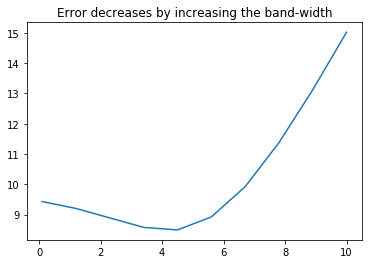

In [180]:
from pyspark.mllib.stat import KernelDensity

def cal_approximated_count_spark(kde, lower, upper, N):
    S = scipy.integrate.quad(lambda x: kde.estimate([x]), lower, upper)
    print("estimated count: ", S[0] * N)
    return S[0] * N

def errors_vs_bandwidth_spark(training_sample, bw_range):
    errors = []
    for bw in bw_range:
        kd = KernelDensity()
        kd.setSample(training_sample)
        kd.setBandwidth(bw)
        approximated = cal_approximated_count_spark(kd, 10, 20, lineitem.count())
        exact = lineitem.where((10 <= lineitem.l_quantity) & (lineitem.l_quantity <= 20)).count()
        errors.append(np.abs((approximated-exact)/exact)*100)
    return errors

bw_range = np.linspace(0.1, 10, 20)
training_sample = lineitem.select('l_quantity').rdd.map(lambda row: float(row[0]) )
errors = errors_vs_bandwidth_spark(training_sample, bw_range)

ax = plt.axes()
plt.plot(bw_range, errors)
ax.set_title("Error decreases by increasing the band-width")

# VARIANCE and STDDEV

SELECT STTDEV(l_quantity), VARIACNE(l_quantity) \
FROM lineitem \
WHERE 10 <= l_quantity <= 20 

In [195]:
exact = lineitem.where((10 <= lineitem.l_quantity) & (lineitem.l_quantity <= 20)).select(stddev('l_quantity'), variance('l_quantity'))
exact.show()

+-----------------------+--------------------+
|stddev_samp(l_quantity)|var_samp(l_quantity)|
+-----------------------+--------------------+
|      3.195026941886337|  10.208197159379559|
+-----------------------+--------------------+



In [196]:
def aqp_variance(kde, lower, upper):
    e_of_square = scipy.integrate.quad(lambda x: x * x * np.exp(kde.score_samples([[x]])), lower, upper)[0] /\
                  scipy.integrate.quad(lambda x: np.exp(kde.score_samples([[x]])), lower, upper)[0]
    sqaure_of_e =(scipy.integrate.quad(lambda x: x * np.exp(kde.score_samples([[x]])), lower, upper)[0] /\
                  scipy.integrate.quad(lambda x: np.exp(kde.score_samples([[x]])), lower, upper)[0] ) ** 2
    var = e_of_square - sqaure_of_e 
    print("The estimated variance is ", var)
    return var

In [200]:
var = aqp_variance(kde, 10, 20)
var2 = aqp_variance(kde2, 10, 20)

The estimated variance is  8.352225579520649
The estimated variance is  8.592058454851411


In [201]:
print('The estimated standard variances are', np.sqrt(var), np.sqrt(var2))

The estimated standard variances are 2.8900217264789982 2.9312213247810903


# AVG

SELECT AVG(l_quantity) \
FROM lineitem \
WHERE 10 <= l_quantity <= 20 

In [202]:
exact = lineitem.where((10 <= lineitem.l_quantity) & (lineitem.l_quantity <= 20)).select(avg('l_quantity'))
exact.show()

+---------------+
|avg(l_quantity)|
+---------------+
|      15.006986|
+---------------+



In [203]:
def aqp_avg(kde, lower, upper):
    exp = scipy.integrate.quad(lambda x: x * np.exp(kde.score_samples([[x]])), lower, upper)[0] /\
                  scipy.integrate.quad(lambda x: np.exp(kde.score_samples([[x]])), lower, upper)[0] 
    print("The estimated average/expectation is ", exp)
    return exp

In [204]:
aqp_avg(kde, 10, 20)
aqp_avg(kde2, 10, 20)

The estimated average/expectation is  15.006785009940241
The estimated average/expectation is  15.007714065312399


15.007714065312399

# Dependent Data

In [151]:
lineitem.select('l_orderkey', 'l_partkey', 'l_suppkey', 'l_linenumber', 'l_quantity', 'l_extendedprice', 'l_discount', 'l_tax', \
                'l_returnflag', 'l_linestatus', 'l_shipdate').show()

+----------+---------+---------+------------+----------+---------------+----------+-----+------------+------------+----------+
|l_orderkey|l_partkey|l_suppkey|l_linenumber|l_quantity|l_extendedprice|l_discount|l_tax|l_returnflag|l_linestatus|l_shipdate|
+----------+---------+---------+------------+----------+---------------+----------+-----+------------+------------+----------+
|         1|   155190|     7706|           1|     17.00|       21168.23|      0.04| 0.02|           N|           O|1996-03-13|
|         1|    67310|     7311|           2|     36.00|       45983.16|      0.09| 0.06|           N|           O|1996-04-12|
|         1|    63700|     3701|           3|      8.00|       13309.60|      0.10| 0.02|           N|           O|1996-01-29|
|         1|     2132|     4633|           4|     28.00|       28955.64|      0.09| 0.06|           N|           O|1996-04-21|
|         1|    24027|     1534|           5|     24.00|       22824.48|      0.10| 0.04|           N|         

In [34]:
# Find the best possible kernel bandwidth
X = l_quantity.values
params = {'bandwidth': np.linspace(-1, 1, 10)}
grid = GridSearchCV(KernelDensity(kernel='gaussian'), params, cv=5)
grid.fit(X)
print("bandwidth selcted : ", grid.best_estimator_.bandwidth)

bandwidth selcted :  0.20000000000000018


In [34]:
# to_select = ['l_discount', 'l_tax'] # the Integral doesn't equal to zero
to_select = ['l_quantity', 'l_extendedprice']
X = lineitem.select(to_select).toPandas()

X[X.columns[0]] = X[X.columns[0]].astype(float)
X[X.columns[1]] = X[X.columns[1]].astype(float)

l_quantity_mean, l_quantity_std = X[X.columns[0]].mean(), X[X.columns[0]].std()
l_extendedprice_mean, l_extendedprice_std = X[X.columns[1]].mean(), X[X.columns[1]].std()

X[X.columns[0]] = (X[X.columns[0]] - l_quantity_mean) / l_quantity_std
X[X.columns[1]] = (X[X.columns[1]] - l_extendedprice_mean) / l_extendedprice_std

X

,l_quantity,l_extendedprice
0,-0.594607,-0.736169
1,0.720474,0.325229
2,-1.217540,-1.072303
3,0.166756,-0.403082
4,-0.110103,-0.665327
...,...,...
19995,1.204977,1.418175
19996,1.412622,2.102577
19997,-0.525392,-0.452476
19998,1.066548,0.719454


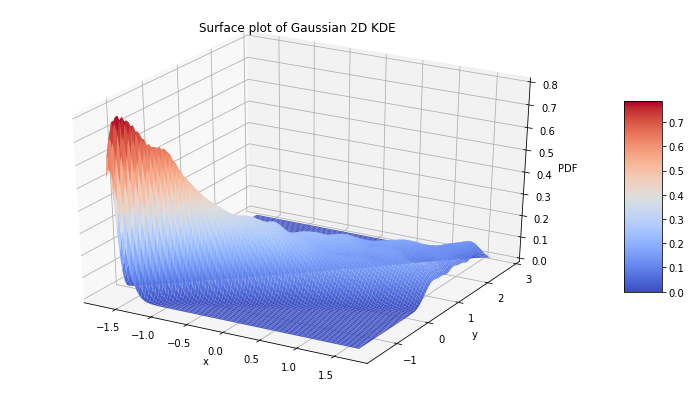

In [35]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=.1).fit(X.values)

# Compute the 3D values and coordinates
x = np.linspace(X[X.columns[0]].min(), X[X.columns[0]].max(), 100)
y = np.linspace(X[X.columns[1]].min(), X[X.columns[1]].max(), 100)
xx, yy = np.meshgrid(x, y)
z = kde.score_samples(list(zip(np.ravel(xx), np.ravel(yy))))
zz = np.exp(z).reshape(xx.shape)

# Plot the 3D prob density distribution
fig = plt.figure(figsize=(13, 7))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xx, yy, zz, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Surface plot of Gaussian 2D KDE')
fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF

In [36]:
np.exp(kde.score_samples([ [5,10000 ] ]))

array([0.])

In [37]:
x_lower, x_upper = -np.inf, np.inf
y_lower, y_upper = -np.inf, np.inf
S = scipy.integrate.dblquad(lambda x, y: np.exp(kde.score_samples([[x,y]])), x_lower, x_upper, lambda x: y_lower, lambda x: y_upper)
# print("the estimated COUNT of rows", S[0] * N)
# return S[0] * N
S

(0.9999999998316692, 1.4854491286379023e-08)

If the integral is zero when integrating from -inf to inf, it means that the values are too large such that they overflow. The input values that are feed into the KDE model should be normalized first to avoid this problem. Accordingly, the output of normalized 

## AVG

SELECT AVG(l_extendedprice) \
FROM lineitem \
WHERE 10 <= l_quantity <= 20 

### Exact

In [48]:
exact = lineitem.where((10 <= lineitem.l_quantity) & (lineitem.l_quantity <= 20)).select(avg('l_extendedprice'))
exact.show()

+--------------------+
|avg(l_extendedprice)|
+--------------------+
|        22410.717711|
+--------------------+



Approximatioin

x -> l_quantity\
y -> l_extendedprice

In [46]:
def inverse_transform(transformed, x_mean, x_std):
    return transformed * x_std + x_mean

inverse_transform(x_lower, l_quantity_mean, l_quantity_std)

10.000000000000002

In [50]:
x_lower, x_upper = (10 - l_quantity_mean) / l_quantity_std, (20 - l_quantity_mean) / l_quantity_std
y_lower, y_upper = -np.inf, np.inf
S = scipy.integrate.dblquad(lambda x, y: inverse_transform(y, l_extendedprice_mean, l_extendedprice_std) * np.exp(kde.score_samples([[x,y]])),\
                            x_lower, x_upper, y_lower, y_upper)
# print("the estimated COUNT of rows", S[0] * N)
# return S[0] * N
S

(4685.965635428413, 0.00012598914737482758)